# Deep learning based diffusive size factors

This notebook illustrates the use of the deep learning based diffusive conductance algorithm decribed [here](https://doi.org/10.1016/j.cageo.2022.105086). PoreSpy's `AI_size_factor` includes the steps for predicting the diffusive size factors of the conduit images. Note that the diffusive conductance of the conduits can be then calculated by multiplying the size factor by diffusivity of the phase. The function takes in the images of segmented porous medium and returns an array of diffusive size factors for all conduits in the image. Therefore, the framework can be applied to both one conduit image as well as a segmented image of porous medium:

<img src="https://user-images.githubusercontent.com/43128873/116145783-bd458380-a6ab-11eb-8103-fb9a93f0599c.png" alt="PS_dl" width="500"/>

# Trained model and supplementary materials
To use the `AI_size_factor`, the tained trained model or weight, and trained data distribution are required. These files based on training images of polydispersed spheres are available to download. Once the required files are downloaded, we can then pass the directory of the files to `AI_size_factor` to be used for predictions.

[trained model weights](link): This file includes only weights of the deep learning layers. To use this file, a Resnet50 model will be built automatically in the `AI_size_factor`.

[trained data distribution](link): This file will be used in denormalizing predicted values based on normalized transform applied on training data.

Import necessary packages and functions:

In [ ]:
import porespy as ps
import scipy as sp
import numpy as np
import h5py
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
import os
import warnings
warnings.filterwarnings("ignore")
path= './AI_example_data/'
path_train= path+'g_train_original.hdf5'
path_weight = path+'model_weights.h5'
g_train = h5py.File(path_train, 'r')['g_train'][()]
model = ps.networks.create_model()
model.load_weights(path_weight)

## Create test image

We can create a 3D image using PoreSpy's `poly_disperese_spheres` generator and segment the image using `snow_partitioning methods`. Note that `find_conns` method returns the connections in the segmented region. The order of values in conns is similar to the network extraction conns. Therefore, the region with label=1 in the segmented image is mapped to indice 0 in conns.

0it [00:00, ?it/s]

  0%|          | 0/199 [00:00<?, ?it/s]

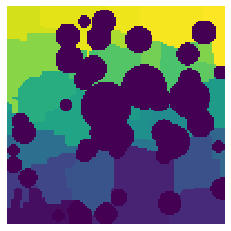

In [2]:
np.random.seed(17)
shape = [120, 120, 120]
dist = sp.stats.norm(loc=7, scale=5)
im = ps.generators.polydisperse_spheres(shape=shape,
                                        porosity=0.7,
                                        dist=dist,
                                        r_min=7)
results = ps.filters.snow_partitioning(im=im.astype(bool))
regions = results['regions']
conns = ps.networks.find_conns(regions)
fig, ax = plt.subplots(1, 1, figsize=[4, 4])
ax.imshow(regions[:,:,20], origin='lower', interpolation='none')
ax.axis(False);

## Apply AI_size_factor

The `AI_size_factor` function has an optional arguemnt to choose the method to predict on the test images. If `tensor_wise=True`, the size factors for all conduits will be calculated once using a tensor of conduit images. By default `tensor_wise=False`, which indicates that the size factors for each conduit will be calculated separately in a for loop. To speedup the calculations, it is recommended to choose `tensor_wise=True`, as tensorflow deep learning model is designed to work with tensors. As the size of the image icreases, the runtime difference between these two options becomes larger.

In [3]:
size_factors = ps.networks.AI_diffusive_size_factor(regions, model= model, g_train=g_train, throat_conns=conns)

2022-04-08 18:06:55.712672: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8303
2022-04-08 18:06:56.476628: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


## Compare with finite difference

Assuming a diffusivity of 1, the diffusive conductance of the conduits will be equal to their size factors. Now let's compare the AI-based diffusive conductances with the conductance values calculated by finite difference method. The finite difference method results are found using the steps explained [here](https://doi.org/10.1016/j.cageo.2022.105086).

The r2 prediction accuracy is 0.95


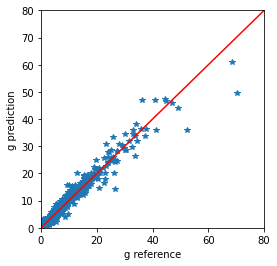

In [4]:
g_FD = h5py.File(path+'g_finite_difference120-phi7.hdf5', 'r') ['g_finite_difference'][()]
g_AI= size_factors
plt.figure(figsize=[4,4])
plt.xlim([0,80])
plt.ylim([0,80])
plt.plot(g_FD,g_AI,'*',[0,80],[0,80],'r')
plt.xlabel('g reference')
plt.ylabel('g prediction')
r2=r2_score(g_FD, g_AI)
print('The r2 prediction accuracy is', np.round(r2,2))

Note on runtime: A larger part of `AI_size_factors` runtime is related to extracting the pairs of conduits, which is the common step required for both AI and finite difference method. Once the data is prepared, AI Prediction on the tensor takes a smaller amount of time in contrast to finite difference method, as it was shown [here]((https://doi.org/10.1016/j.cageo.2022.105086)). 

## Apply on one conduit

In [5]:
pair_in=h5py.File(path+'pair.hdf5', 'r')
im = pair_in['pair'][()]
conns = ps.networks.find_conns(im)
diffusive_size_factor_FD = pair_in['size_factor'][()]
diffusive_size_factor_AI = ps.networks.AI_diffusive_size_factor(im, model= model, g_train=g_train, throat_conns=conns)
print('diffusive size factor from FD and AI:', diffusive_size_factor_FD, diffusive_size_factor_AI)

  0%|          | 0/2 [00:00<?, ?it/s]

diffusive size factor from FD and AI: [9.869504] [9.90831661]
